<IPython.core.display.Javascript object>


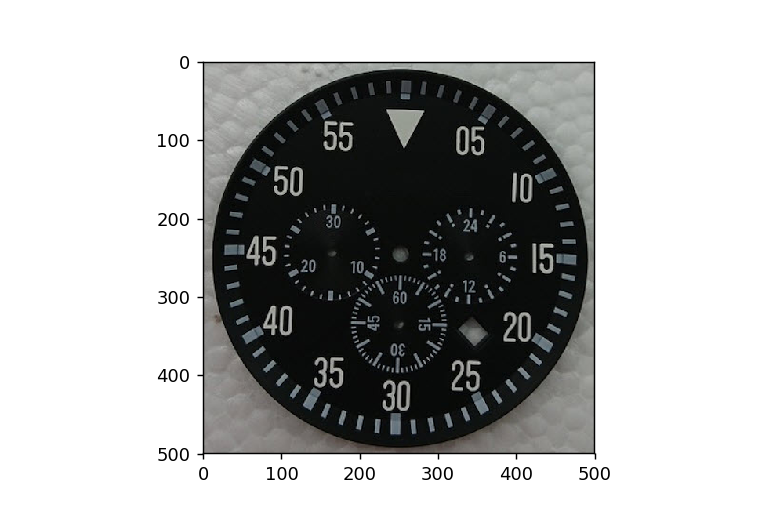

9

In [37]:
import numpy as np
import cv2
import os
from skimage.measure import compare_ssim
from skimage import io
from skimage.filters import threshold_mean, gaussian
from skimage.util import img_as_ubyte, img_as_float
from skimage.color import gray2rgb, rgb2grey
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
%matplotlib notebook
%config InlineBackend.close_figures=False 

SAVE_TITLE = "watch_labels.txt"
fig,ax = plt.subplots()
img = io.imread("sample/black_dials/good.png")
pic = img.copy()
ax.imshow(pic)
global drawmode
drawmode = "roi_box"
global pos, digits
pos = []; digits = []; key = []; rois = [];

def plot_bboxes(points, ax, color):
    for i in range(0, len(points)- len(points)%2, 2):
        p1 = points[i]
        p2 = points[i+1]
        lower_left_point = (min(p1[0],p2[0]), min(p1[1],p2[1]))
        upper_right_point = (max(p1[0],p2[0]), max(p1[1],p2[1]))
        w = max(p1[0],p2[0]) - min(p1[0], p2[0])
        h = max(p1[1],p2[1]) - min(p1[1], p2[1])
        rect = Rectangle(lower_left_point,w,h,linewidth=1,edgecolor=color,facecolor='none')
        ax.add_patch(rect)
def save_roi():
    # TODO THIS NEEDS TO CHANGGGGGGGE
    # TODO 2: careful about the x/y, i/j thing in opencv/skimage
    with open(SAVE_TITLE, "w") as savefile:
        general_roi = "".join(["{};{};roi; \n".format(i1,j1,i2,j2) for (i,j) in pos])
        digit_roi = "".join(["{};{};digit; \n".format(i,j) for (i,j) in digits])
        savefile.write(general_roi)
        savefile.write(digit_roi)
    
def onclick(event):
    if drawmode == "roi_box":
        pos.append((event.xdata,event.ydata))
    elif drawmode == "digits":
        digits.append((event.xdata,event.ydata))
    ax.scatter(*zip(*pos), color="red", s=4)
    # ax.scatter(*zip(*digits), color="green", s=4)
    plot_bboxes(pos, ax, "green")
    plot_bboxes(digits, ax, "blue")
    fig.show()

def onkey(event):
    if event.key == "u":
        key.append("resetting labels")
        plt.cla()
        global pos, digits
        pos = []; digits = [];
        pic = img.copy()
        ax.imshow(pic)
        fig.show()
    elif event.key == "d":
        key.append("labeling digits")
        global drawmode
        drawmode = "digits"
    elif event.key == "r":
        key.append("r registered")
        drawmode = "roi_box"
    elif event.key == "s":
        key.append("s registered")
        save_roi()
    #print "you pressed {} {} {}".format(event.key, event.xdata, event.ydata)
fig.canvas.mpl_connect('key_press_event', onkey)
fig.canvas.mpl_connect('button_press_event', onclick)

In [177]:
print key
print pos
print digits

with open(SAVE_TITLE, "w") as savefile:
    general_roi = "".join(["{};{};roi; \n".format(i,j) for (i,j) in pos])
    digit_roi = "".join(["{};{};digit; \n".format(i,j) for (i,j) in digits])
    savefile.write(general_roi)
    savefile.write(digit_roi)

['r registered', 'labeling digits', 'resetting labels', 'labeling digits', 'resetting labels', 'r registered', 'labeling digits', 'resetting labels', 'r registered', 'labeling digits', 'resetting labels', 'labeling digits', 'r registered', 'labeling digits', 's registered']
[(224.30782627445365, 52.864951473420888), (295.59185865120128, 124.14898385016846)]
[(146.12533915156916, 68.961345881073498), (199.01349220528516, 131.04743859630531), (86.338731351716319, 128.74795368092634), (134.62791457467443, 179.33662181926337), (54.145942536410985, 218.42786538070561), (102.43512575936904, 269.01653351904264), (72.541821859442621, 308.10777708048488), (123.13048999777965, 356.39696030344294), (136.92739949005335, 374.79283962647457), (192.11503745914831, 429.98047759556948), (222.00834135907473, 400.08717369564306), (272.5970094974117, 452.97532674935906), (313.98773797423291, 372.49335471109561), (359.97743628181206, 425.38150776481154), (378.3733156048437, 315.00623182662173), (428.961983

In [2]:
with open(SAVE_TITLE,"r") as readfile:
    dr = []
    br = []
    for line in readfile.readlines():
        lit = line.replace("\n","").split(";")
        # print lit
        if lit[2] == "digit":
            dr.append([float(n) for n in lit[:2]])
        elif lit[2] == "roi":
            br.append([float(n) for n in lit[:2]])
print dr[0]

[146.125339152, 68.9613458811]


['50', '50', '45', '40', '35', '30', '25', '20', '5', '10', '05']
0.248850107193


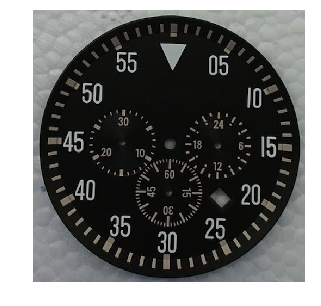

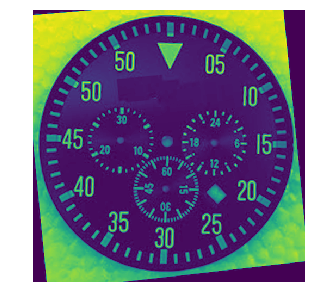

In [36]:
# copied for more work...
## compare stuff here:
from PIL import Image
import pytesseract
import time
from keras.models import load_model
%matplotlib inline

model = load_model('my_model.h5')
begin = time.time()

def quick_fig(img):
    plt.figure(figsize=(16,5)) 
    plt.imshow(img)
    plt.axis("off")
gd = cv2.imread("sample/black_dials/good.png")
bd = io.imread("sample/black_dials/macho_libre.png")

def cycle_over_digit_rois(img, roi_list):
    """
    Cycle over coordinate list of digit-containing regions on image and return
    dictionary of probable numeric values
    """
    digit_predictions = []
    # split up list into twos (may change later)
    for i in range(0, len(roi_list)- len(roi_list)%2, 2):
        x1,y1 = [int(n) for n in roi_list[i]]
        x2,y2 = [int(n) for n in roi_list[i+1]]
        # xmid= int(x1+(x2-x1)/2)
        sub_roi = img.copy()[y1:y2,x1:x2]
        digits = preprocess_digits(sub_roi)
        # quick_fig(np.hstack(digits))
        text = ""
        for d in digits:
            nn_input = d.copy()
            nn_input = np.expand_dims(nn_input, axis=0)
            nn_input = np.expand_dims(nn_input, axis=0)
            prediction = model.predict(nn_input,verbose=0)
            text+=str(np.argmax(prediction))
            # print(dildo)
        digit_predictions.append(text)
    return digit_predictions

print cycle_over_digit_rois(bd, dr)
print time.time() - begin
# print pytesseract.image_to_string(Image.open('tess_work.png'))
quick_fig(gd)
quick_fig(bd)
plt.show()


In [31]:
def preprocess_digits(roi):
    """
    Blurs and thresholds a roi, returns list of image sections potentially containing digits
    as numpy arrays; reformatted to 28*28 for MNIST-style digit recognition
    """
    regions = []
    small = roi.copy()
    if len(small.shape) > 2:
        small = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    small = cv2.medianBlur(small,3)
    _, small = cv2.threshold(small,100, 255,cv2.THRESH_BINARY)
    cnts = cv2.findContours(small.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts = sort_contours(cnts, method="left-to-right")[0]
    for cn in cnts:
        # compute the bounding box of the contour and draw it on our
        # image
        (x, y, w, h) = cv2.boundingRect(cn)
        # check that the bounding box of the putative number takes up at least 5% of roi area:
        if w*h*1.0/(small.shape[0]*small.shape[1]) > 0.05:
            potential_digit = small.copy()[y:y+h, x:x+w]
            potential_digit = cv2.copyMakeBorder(potential_digit,7,7,7,7,cv2.BORDER_CONSTANT)#,value=np.minimum(potential_digit))
            potential_digit = cv2.resize(potential_digit, (28,28))
            regions.append(potential_digit)
    return regions

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

(500, 500, 3) (510, 510, 3)


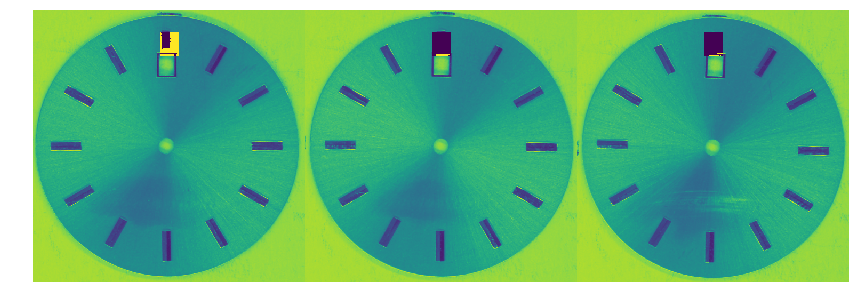

In [161]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk


## compare stuff here:
%matplotlib inline
def quick_fig(img):
    plt.figure(figsize=(16,5)) 
    plt.imshow(img)
    plt.axis("off")
white1 = cv2.imread("good_cropped/g0.png")
white1 = cv2.cvtColor(white1, cv2.COLOR_BGR2GRAY)
white2 = cv2.imread("good_cropped/g4.png")
white2 = cv2.cvtColor(white2, cv2.COLOR_BGR2GRAY)
badwhite = cv2.imread("good_cropped/b3.png")
badwhite = cv2.cvtColor(badwhite, cv2.COLOR_BGR2GRAY)

# quick_fig(np.hstack([white1,white2, badwhite]))

with open("watch_labels_white.txt","r") as readfile:
    dr = []
    br = []
    for line in readfile.readlines():
        lit = line.replace("\n","").split(";")
        # print lit
        if lit[2] == "digit":
            dr.append([float(n) for n in lit[:2]])
        elif lit[2] == "roi":
            br.append([float(n) for n in lit[:2]])

for i in range(0, len(br)- len(br)%2, 2):
    x1,y1 = [int(n) for n in br[i]]
    x2,y2 = [int(n) for n in br[i+1]]
    threshes = []
    for IM in (white1,white2,badwhite):
        # print threshold_mean(IM[y1:y2,x1:x2])
        current = IM[y1:y2,x1:x2]
        
        comparison = white1[y1:y2,x1:x2]
        # thresh = (np.mean(comparison)+np.mean(current))/2.0
        thresh = np.mean(comparison)
        current[current>thresh]=255
        current[current<thresh]=0
        _ = """
        ### super project for phat contours ### 
        
        current_contours = current.copy()
        
        current_contours = cv2.medianBlur(current_contours,3)
        current_contours = cv2.copyMakeBorder(current_contours,7,7,7,7,cv2.BORDER_REPLICATE)
        # _, current_contours = cv2.threshold(current_contours,thresh, 255,cv2.THRESH_BINARY)
        
        ### experiment with tophat start
        disksize = int(min(current.shape)*0.2)
        print disksize
        selem = disk(disksize)
        eroded = erosion(current_contours, selem)
        current = eroded
        ### experiment with tophat over
        
        # quick_fig(current_contours)
        cnts = cv2.findContours(current_contours.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        for cn in cnts:
            (x, y, w, h) = cv2.boundingRect(cn)
            # check that the bounding box of the putative number takes up at least 30% of roi area:
            if w*h*1.0/(current.shape[0]*current.shape[1]) > 0.3:
                # cv2.rectangle(current, (x, y), (x + w, y + h), 255, -1)
                pass
            else:
                # print "small_un"
                # cv2.rectangle(current, (x, y), (x + w, y + h), 255, -1)
                pass
        quick_fig(current_contours)
                #potential_digit = current_contours.copy()[y:y+h, x:x+w]
                #potential_digit = cv2.copyMakeBorder(potential_digit,5,5,5,5,cv2.BORDER_CONSTANT)#,value=np.minimum(potential_digit))
                #potential_digit = cv2.resize(potential_digit, (28,28))
        # cnts = sort_contours(cnts, method="left-to-right")[0]
        # print [c.shape for c in cnts]
        ### phat contours end ### 
        """
        _ = """
        print "current:", np.median(current)
        print "comparison", thresh

        print " "
        """
        #current[current>thresh] = 255
        #current[current<thresh] = 0
        #nu_thresh = np.mean(current)
        # threshes.append(nu_thresh)
    break
    #print threshes[0] - threshes[1]
    #print threshes[2] - threshes[0]
    _ = """
    if abs(threshes[2] - threshes[0]) > 5*abs(threshes[1] - threshes[0]):
        print "discrepancy", abs(threshes[2] - threshes[0]), abs(threshes[1] - threshes[0])
        # cv2.rectangle(badwhite, (x1,y1), (x2,y2), 255, -1)
        for IM in (gd1,gd2,bd):
            #(gd1,gd2,bd):
            # tungalunga = threshes[2] - threshes[0]
            # cv2.rectangle(IM, p1, p2, (0,0,255), -1)
            pass
    # print "newline"
        #cv2.rectangle(IM, p1, p2, (0,0,255), -1)
"""
print gd.shape, bd.shape
quick_fig(np.hstack([white1,white2, badwhite]))
# image2